In [38]:
import re
import fasttext
import numpy as np
import pandas as pd

from underthesea import word_tokenize
from gensim.utils import simple_preprocess
from keras.preprocessing.sequence import pad_sequences

# 1. Word embedding caption

In [2]:
data = pd.read_csv('data/captions_vi.csv')
data.head()

,file_name,nums,caps
0,1332722096_1e3de8ae70.jpg,#0,Ba người phụ nữ đứng trên một con phố trong th...
1,1332722096_1e3de8ae70.jpg,#1,Ba người phụ nữ đi bộ xuống phố
2,1332722096_1e3de8ae70.jpg,#2,Hai cô gái và một người phụ nữ đi bộ trên vỉa hè
3,1332722096_1e3de8ae70.jpg,#3,Hai cô gái đi ủng màu xanh lá cây tươi sáng v...
4,1332722096_1e3de8ae70.jpg,#4,Hai cô gái trẻ đi ủng màu xanh lá cây đang đi...


In [4]:
def clean_text(text):
    my_punct = '[!"\#\$%\&\(\)\*\+,/:;<=>\?@\[\\\]\^_—`.\{\|\}\~»«“”]\r'
    trans = str.maketrans('', '', my_punct)
    text = text.translate(trans)
    text = text.lower().split()
    text = ' '.join(text)
    return text

def remove_emojis(string):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f" 
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', string)

data['caps'] = data['caps'].map(lambda x: clean_text(x))
data['caps'] = data['caps'].map(lambda x: remove_emojis(x))

In [9]:
data = data[['file_name', 'caps']]

In [10]:
data.head()

,file_name,caps
0,1332722096_1e3de8ae70.jpg,ba người phụ nữ đứng trên một con phố trong th...
1,1332722096_1e3de8ae70.jpg,ba người phụ nữ đi bộ xuống phố
2,1332722096_1e3de8ae70.jpg,hai cô gái và một người phụ nữ đi bộ trên vỉa hè
3,1332722096_1e3de8ae70.jpg,hai cô gái đi ủng màu xanh lá cây tươi sáng và...
4,1332722096_1e3de8ae70.jpg,hai cô gái trẻ đi ủng màu xanh lá cây đang đi ...


In [26]:
pad_token, pad_id = '<pad>', 0
sos_token, sos_id = '<sos>', 1
eos_token, eos_id = '<eos>', 2

def word_preprocessing(sen):
    sen = " ".join(simple_preprocess(sen))
    sen = [w for w in word_tokenize(sen.lower(), format='text').split()]
    sen = [sos_token] + sen + [eos_token]
    return [w for w in sen if w != '']

In [27]:
corpus = data['caps'].values.tolist()
corpus = list(map(word_preprocessing, corpus))

In [31]:
vocab = dict()

vocab[pad_token] = pad_id
vocab[sos_token] = sos_id
vocab[eos_token] = eos_id

max_words = 0

for sen in corpus:
    for word in sen:
        if word not in vocab:
            vocab[word] = len(vocab)
    max_words = max(max_words, len(sen))
            
inverse_vocab = {idx: word for word, idx in vocab.items()}
vocab_size = len(vocab)
print('vocab size:', vocab_size)
print('max lenghts:', max_words)

vocab size: 5570
max lenghts: 43


In [33]:
matrix_wv = []
for sen in corpus:
    matrix_wv.append([vocab[word] for word in sen])

In [36]:
X = pad_sequences(matrix_wv, maxlen=max_words, value=0, padding='post')
X.shape

(40000, 43)

In [21]:
embedding_idx = fasttext.load_model(r'D:\Projects\NLP\TextClassification\data\cc.vi.300.bin')

In [39]:
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in vocab.items():
    embedding_vector = embedding_idx[word]
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 5570 words (0 misses)


In [42]:
embedding_matrix.shape

(5570, 300)

In [43]:
np.save('data/embedding_matrix.npy', embedding_matrix)

# 2. Extract feature from image

In [29]:
import numpy as np

from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [32]:
model = VGG16(weights='imagenet')
# remove 2 fully connected layer
model = Model(model.input, model.layers[-2].output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

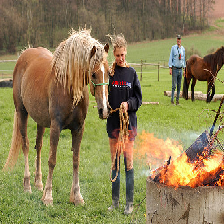

In [34]:
img_base_path = 'data/sample/'
file_name = '10815824_2997e03d76.jpg'
img_path = lambda file_name: img_base_path + file_name

img = image.load_img(img_path(file_name), color_mode='rgb', target_size=(224, 224))
display(img)

In [ ]:
model.